<h1 style="text-align: center;">Classifying Pneumonia in Chest X-Rays</h1>


![Doctor holding x-ray image](photos/Doctor-holding-image-of-chest-xray.jpg)


## Project Summary
***
In this project, I tackled the business problem of developing an AI-powered system to detect pneumonia in chest X-ray images for a medical technology company. The data used for this task consisted of a large dataset of labeled chest X-ray images, with two classes, "Pneumonia" and "Normal." The dataset was well-suited for the business problem, as it provided a diverse sample of X-rays that included both viral and bacterial pneumonia cases as well as pneumonia free cases.

For data preparation, I utilized the Keras library to ensure uniformity in image sizes and enhance model performance by resizing images to 224x224 pixels and normalizing pixel values to a range between 0 and 1. 

In the modeling phase, I implemented Convolutional Neural Networks (CNNs) and transfer learning techniques. For the CNNs, I used multiple convolutional and max-pooling layers for detecting simple patterns such as edges and corners, followed by dense layers for high-level reasoning and classification. For transfer learning, I leveraged the pre-trained model, Xception, and fine-tuned top Dense layers on the X-ray dataset. 

To evaluate the models, I used binary cross-entropy loss, model accuracy, and recall as relevant metrics. The data was split into training and validation sets to assess model generalization. The models where then evaluated on an unseen test set. The final transfer learning model was the most successful. It not only achieved the highest accuracy of 84%, but also it had an excellent recall score of 98% and the highest avg weighted recall score of the models at 84%. 

Overall, the project successfully addressed the business problem by delivering an AI-powered pneumonia detection system that can be integrated into the company's medical imaging products. 

## Business Problem
***
A medical technology company wants an AI-powered system that detects pneumonia in chest X-rays. They have hired me to develop a model that can be implemented into their medical imaging products in order to assist radiologists with reading X-rays and flagging potential cases of pneumonia. The goal is to provide radiologists with cutting-edge technology that can aid them in interpreting X-rays accurately and efficiently, leading to quicker and more accurate diagnoses.

## Data Understanding
***
The dataset used in this project was downloaded from kaggle.com. It consists of chest X-ray images categorized into two classes, "Pneumonia" and "Normal." The data provides a diverse range of X-rays, allowing the model to learn patterns and features related to pneumonia detection. With 5,863 labeled images, the dataset is sufficiently large enough to train a robust model.

To begin the project, I will import the relevant packages needed for data analysis and deep learning: 

In [1]:
#Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tabulate import tabulate
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import EarlyStopping
from keras import layers
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.datasets import mnist
from keras.applications import Xception
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.transform import resize
import os

# Set environment variables
os.environ['KMP_DUPLICATE_LIB_OK']='True' 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# set random seed for reproducability 
np.random.seed(42)
tf.random.set_seed(42)

2023-07-26 15:10:07.777077: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Next, I will load the data, which is already split into training, validation, and testing sets. During the data loading process, I will perform some preprocessing steps, including normalizing the pixel sizes and resizing the images to a standard size. 

In [2]:
# Load the Data
# Specify the path to the data folder
data_folder = 'Data/chest_xray'

# Create an instance of the ImageDataGenerator
data_generator = ImageDataGenerator(rescale=1.0/255.0)  # Normalize pixel values between 0 and 1

# Load the training data
train_data = data_generator.flow_from_directory(
    os.path.join(data_folder, 'train'),  # Path to the training data folder
    target_size=(224, 224),  # Resize the images to a suitable size
    batch_size=32, 
    class_mode='binary',  # Pneumonia and non-pneumonia
    shuffle=True # Reduce the risk of order bias during training
)

# Load the validation data
val_data = data_generator.flow_from_directory(
    os.path.join(data_folder, 'val'),  # Path to the validation data folder
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  
)

# Load the testing data
test_data = data_generator.flow_from_directory(
    os.path.join(data_folder, 'test'),  # Path to the testing data folder
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5152 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Next, I want to visualize a few images from a batch to check that everything loaded as expected and to get a glimpse of the data.

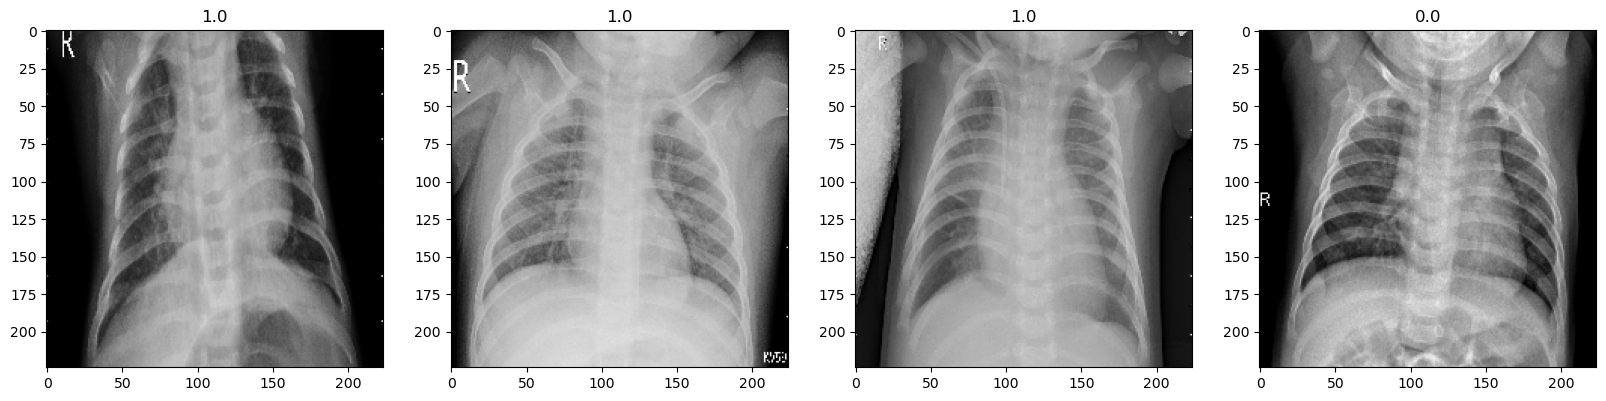

In [3]:
# Retrieve a batch of data from the train_data generator
batch = next(train_data)

# Visualise the first four images from a batch
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].set_title(batch[1][idx])

plt.show()


Looking at the images above, 0 represents normal and 1 represents pneumonia. So the batch contains both normal and pneumonia images. This is a good thing! It means that the shuffling during loading worked. Now, I want to visualise more images looking at 5 normal X-rays and 5 pneumonia X-rays to compare. 

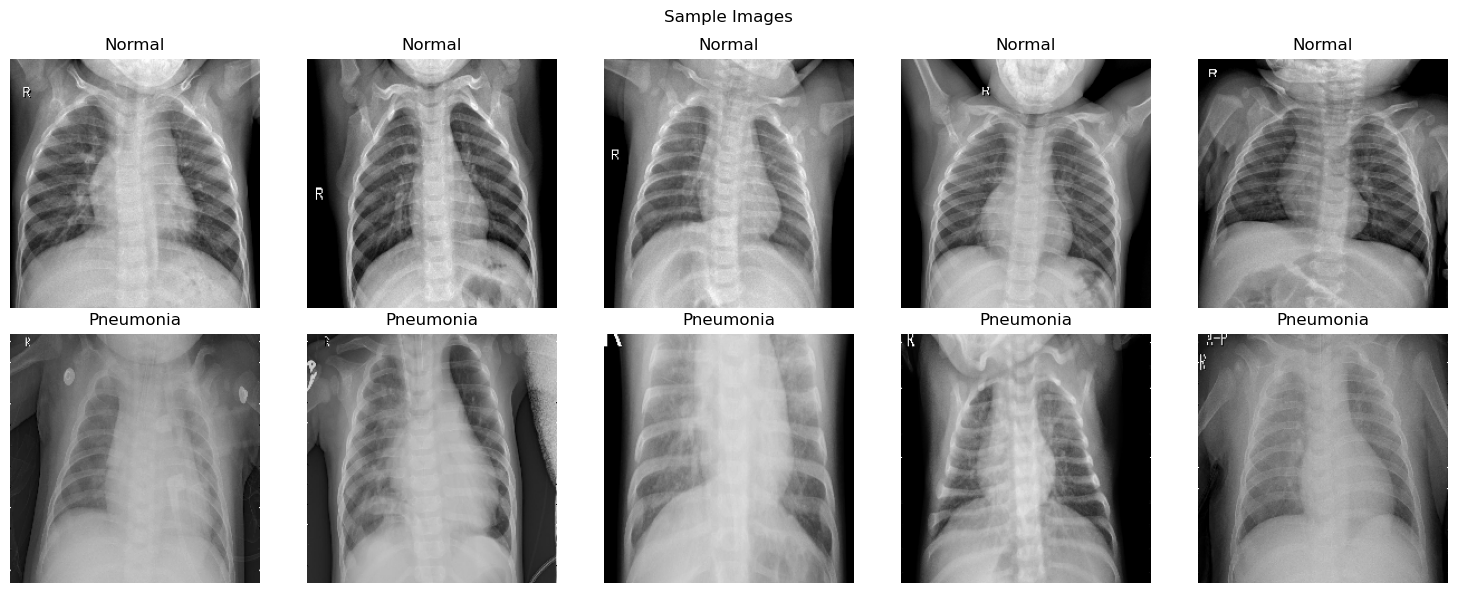

In [4]:
# Visualization 
num_samples_per_class = 5
class_names = ['Normal', 'Pneumonia']

fig, axes = plt.subplots(nrows=2, ncols=num_samples_per_class, figsize=(15, 6))

# Loop through the classes
for i in range(len(class_names)):
    class_samples = []
    
    # Loop through the batches of data in the training set
    for batch in train_data:
        # Find the indices where the label is equal to the current class index (i)
        indices = np.where(batch[1] == i)[0]

        # If there are samples of the current class in this batch
        if len(indices) > 0:
            # Extend the class_samples list with the corresponding image samples
            class_samples.extend(batch[0][indices])

        # Check if we have collected enough samples for the current class
        if len(class_samples) >= num_samples_per_class:
            break

    # Loop over the sample images of the current class and display them in the figure
    for j, sample in enumerate(class_samples[:num_samples_per_class]):
        # Show the image on the current subplot
        axes[i, j].imshow(sample)

        # Turn off axis labels for better visualization
        axes[i, j].axis('off')

        # Set the title of the subplot to the current class name
        axes[i, j].set_title(class_names[i])

plt.suptitle('Sample Images')
plt.tight_layout()
plt.show()



Now that I have seen what the images look like for each class, I will look at the class distribution. I will organise this within a table, which shows the number of samples for each class in the training, validation, and test sets:

In [5]:
# Class Distribution
train_count = np.sum(train_data.labels == 1)
val_count = np.sum(val_data.labels == 1)
test_count = np.sum(test_data.labels == 1)

# Prepare data for the table
table_data = [[class_names[1], train_count, val_count, test_count], 
              [class_names[0], train_data.samples - train_count, val_data.samples - val_count, test_data.samples - test_count]]
table_headers = ["Class", "Train Count", "Validation Count", "Test Count"]

# Display the class distribution table
table = tabulate(table_data, headers=table_headers, tablefmt="grid")
print(table)




+-----------+---------------+--------------------+--------------+
| Class     |   Train Count |   Validation Count |   Test Count |
+===========+===============+====================+==============+
| Pneumonia |          3843 |                 40 |          390 |
+-----------+---------------+--------------------+--------------+
| Normal    |          1309 |                 40 |          234 |
+-----------+---------------+--------------------+--------------+


This disparity in class representation raises concerns about class imbalance. In machine learning and deep learning tasks, class imbalance can impact model performance and bias the predictions towards the majority class. In this dataset, the "Pneumonia" class is the majority class, while the "Normal" class is the minority class. This is something that I will keep in mind when evaluating my models. There are techniques I can implement such as creating synthetic data to add to the normal set to offset the imbalance; however, I am more concerned with classifying pneumonia correctly than miss-classifying healthy X-rays. I will keep in mind the imbalance when looking at the results and for now see how my models perform. 

## CNN Modeling
***

I will be using CNN (Convolutional Neural Networks) for this project because they are well-suited for image recognition tasks, allowing me to efficiently detect patterns and features in the chest X-ray images. 

I will be creating quite a few CNN models, so to streamline the process, I will create two functions. The first will provide a convenient way to compile and train a model, and I will include an early stopping mechanism to prevent overfitting and enhance model generalization. The second function will be used to evaluate the model during training and on the test set. 

In [6]:
def run_model(model):
    """
    run_model will take in a built model and compile and fit to the training data. It will return training history. 
    """
    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Compile the model 
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model with early stopping and class weights
    history = model.fit(train_data, epochs=100, validation_data=val_data, callbacks=[early_stopping])
    return history
   

In [7]:
#Create Function for evaluation of model, confusion matrix, and classification report

def evaluation(model, history):
    '''
    Function takes in a model and outputs a
    confusion matrix and classification report
    '''
    # Display a summary of the model's structure
    print(model.summary())
    
    # Plot training and validation loss to visualize model performance
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy to visualize model performance
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Evaluate the model's performance on the test data
    test_loss, test_accuracy = model.evaluate(test_data, steps=len(test_data))
    print('Test Loss:', test_loss)
    print('Test Accuracy:', test_accuracy)
    
    
    # Get the predicted probabilities for the test data
    predictions = model.predict(test_data).flatten()  

    # Convert probabilities to binary predictions (0 or 1)
    binary_predictions = np.round(predictions)

    # Get the true labels of the test data
    true_labels = test_data.labels
    
    # Generate the classification report to show precision, recall, F1-score, and support for each class
    report = classification_report(true_labels, binary_predictions)
    print(report)
    
    # Micro-averaged recall (overall recall)
    micro_recall = recall_score(true_labels, binary_predictions, average='micro')
    print('Overall recall', micro_recall)

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, binary_predictions)

    # Plot the confusion matrix
    labels = ['Healthy', 'Pneumonia']  
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Compute the Area Under the ROC Curve (AUC/ROC) to assess model discrimination

    # Get the model's predicted probabilities for the test and validation data
    test_predictions = model.predict(test_data).ravel()
    val_predictions = model.predict(val_data).ravel()

    # Get the true labels of the test and validation data
    test_labels = test_data.labels
    val_labels = val_data.labels

    # Compute the AUC for the test and validation data
    test_auc = roc_auc_score(test_labels, test_predictions)
    val_auc = roc_auc_score(val_labels, val_predictions)

    # Compute the False Positive Rate (FPR) and True Positive Rate (TPR) for the ROC curve
    test_fpr, test_tpr, _ = roc_curve(test_labels, test_predictions)
    val_fpr, val_tpr, _ = roc_curve(val_labels, val_predictions)

    # Plot the ROC curve for test and validation data to visualize model performance
    plt.figure(figsize=(8, 6))
    plt.plot(test_fpr, test_tpr, label='Test ROC Curve (AUC = {:.2f})'.format(test_auc))
    plt.plot(val_fpr, val_tpr, label='Validation ROC Curve (AUC = {:.2f})'.format(val_auc))

    # Plot the diagonal line representing a random classifier (no discrimination)
    plt.plot([0, 1], [0, 1], 'k--')

    # Set plot labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


### MODEL 1
I will start by creating a baseline CNN model.

In [32]:
# Build a baseline CNN model
CNN_baseline = Sequential()

# Conv2D layer to extract relevant features from the input images 
CNN_baseline.add(Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)))

# MaxPooling layer to downsample the feature maps 
CNN_baseline.add(MaxPooling2D(pool_size=(2,2)))

# Flatten layer to transform from 2D to 1D for the Dense layer to take as an input
CNN_baseline.add(Flatten())

# Dense layer to perform high-level reasoning and classification
CNN_baseline.add(Dense(128, activation='relu'))

# Output layer with activation sigmoid for binary classification
CNN_baseline.add(Dense(1, activation='sigmoid'))


In [10]:
# Train the CNN model and get the history object
CNN_history = run_model(CNN_baseline)



Epoch 1/100


2023-07-26 15:10:16.061014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


161/161 [==============================] - ETA: 0s - loss: 1.2182 - accuracy: 0.8837

2023-07-26 15:12:40.964549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


161/161 [==============================] - 146s 900ms/step - loss: 1.2182 - accuracy: 0.8837 - val_loss: 0.4464 - val_accuracy: 0.7875
Epoch 2/100
161/161 [==============================] - 138s 857ms/step - loss: 0.0669 - accuracy: 0.9753 - val_loss: 0.1343 - val_accuracy: 0.9250
Epoch 3/100
161/161 [==============================] - 131s 810ms/step - loss: 0.0447 - accuracy: 0.9833 - val_loss: 0.4361 - val_accuracy: 0.7875
Epoch 4/100
161/161 [==============================] - 132s 818ms/step - loss: 0.0187 - accuracy: 0.9961 - val_loss: 0.4509 - val_accuracy: 0.8125
Epoch 5/100
161/161 [==============================] - 144s 894ms/step - loss: 0.0082 - accuracy: 0.9986 - val_loss: 0.0845 - val_accuracy: 0.9750
Epoch 6/100
161/161 [==============================] - 139s 862ms/step - loss: 0.0029 - accuracy: 0.9998 - val_loss: 0.1807 - val_accuracy: 0.9250
Epoch 7/100
161/161 [==============================] - 132s 819ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2796 - val_

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 128)               50466944  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 50,467,969
Trainable params: 50,467,969
Non-trainable params: 0
____________________________________________

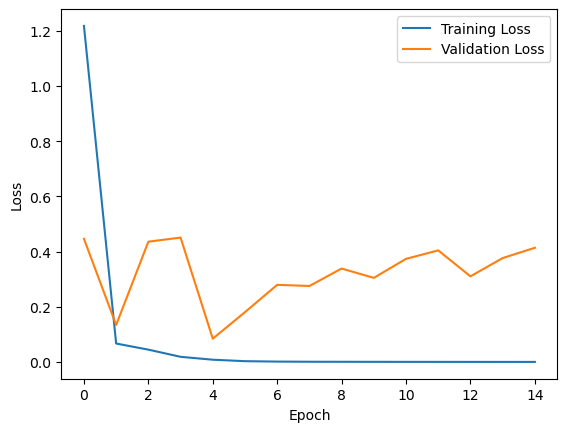

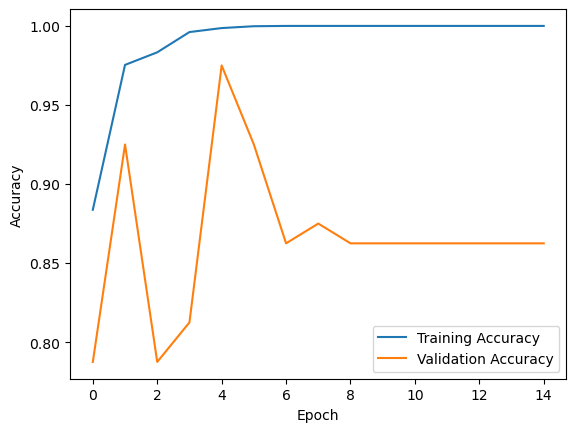

2023-07-26 15:44:27.150928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 7s 341ms/step - loss: 0.9477 - accuracy: 0.7933
Test Loss: 0.947723388671875
Test Accuracy: 0.7932692170143127


2023-07-26 15:44:35.330404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 8s 348ms/step
              precision    recall  f1-score   support

           0       0.97      0.46      0.63       234
           1       0.75      0.99      0.86       390

    accuracy                           0.79       624
   macro avg       0.86      0.73      0.74       624
weighted avg       0.84      0.79      0.77       624

Overall recall 0.7932692307692307


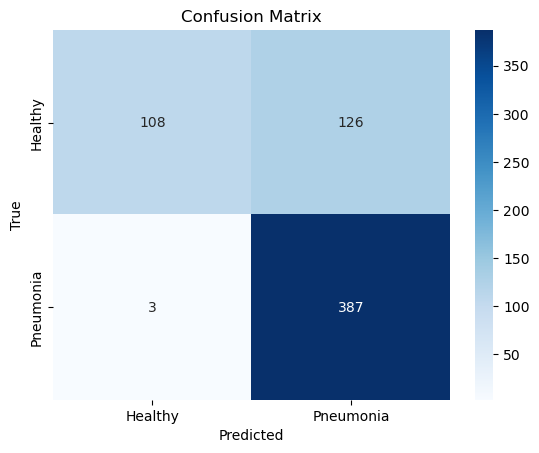

2023-07-26 15:44:43.930688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 7s 343ms/step


2023-07-26 15:44:51.855182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3/3 [==============================] - 1s 223ms/step


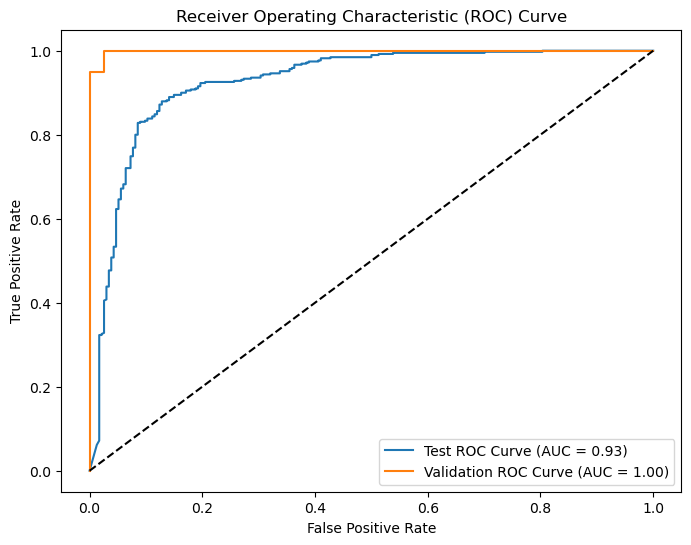

In [11]:
# Evaluate the model using the history object
CNN_baseline_evaluation = evaluation(CNN_baseline, CNN_history)

#### Model Evaluation

I used the test dataset to assess the model's generalization ability on unseen data. The model achieved an accuracy of 79.33% on the test set, and a loss of 0.95 demonstrating its overall correctness in predicting both classes.

The confusion matrix provided insights into the model's performance by revealing the true positive, true negative, false positive, and false negative predictions for each class. 
True Positive (TP): The model correctly identified 387 Pneumonia cases as positive instances.
True Negative (TN): The model correctly identified 108 Normal cases as negative instances.
False Positive (FP): The model misclassified 126 Normal cases as Pneumonia, leading to false positives.
False Negative (FN): The model missed 3 Pneumonia case, resulting in false negatives.

Moreover, the model achieved a recall (true positive rate) of 0.99 for Pneumonia cases in the test set, indicating its strong ability to correctly identify positive cases. However, the recall for Normal cases was only 0.46, suggesting room for improvement in correctly recognizing Normal cases. The overall recall was 0.79.

Additionally, the area under the Receiver Operating Characteristic curve (ROC AUC score) for the test set was 0.93. The ROC curve illustrates the model's performance across various classification thresholds, and an AUC score closer to 1 indicates better discriminatory power. The achieved score of 0.93 indicates good model performance in distinguishing between Pneumonia and Normal cases. 

Overall, the baseline CNN model demonstrated promising results, particularly in identifying Pneumonia cases accurately. However, it showed some limitations in correctly classifying Normal cases. Fine-tuning the model or exploring different architectural adjustments may further enhance its performance on the test set and improve its sensitivity to Normal cases.

I will go ahead and save the model so that it will not need to be re-trained in the future. 

In [31]:
# Save Model 
CNN_baseline.save('CNN_baseline_.h5')

### MODEL 2

Things to add to the baseline model to try and increase performance:
1. Three convolutional layers (instead of 1) with increasing filter sizes (32, 64, 128).
2. A dropout layer with a dropout rate of 0.5 to reduce overfitting.


In [13]:
CNN_model_2 = Sequential(name='CNN_model_2')

# 1st Conv2D layer 
CNN_model_2.add(Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)))
CNN_model_2.add(MaxPooling2D(pool_size=(2,2)))

# 2nd Conv2D layer 
CNN_model_2.add(Conv2D(64, (3,3), activation='relu'))
CNN_model_2.add(MaxPooling2D(pool_size=(2,2)))

# 3rd Conv2D layer 
CNN_model_2.add(Conv2D(128, (3,3), activation='relu'))
CNN_model_2.add(MaxPooling2D(pool_size=(2,2)))

# Flatten layer 
CNN_model_2.add(Flatten())

# Dense layer 
CNN_model_2.add(Dense(128, activation='relu'))
# Dropout layer to to reduce overfitting
CNN_model_2.add(Dropout(0.5))

# Output layer 
CNN_model_2.add(Dense(1, activation='sigmoid'))

In [14]:
CNN_history = run_model(CNN_model_2)

Epoch 1/100


2023-07-26 15:44:54.450386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


161/161 [==============================] - ETA: 0s - loss: 0.3435 - accuracy: 0.8599

2023-07-26 15:47:43.136015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


161/161 [==============================] - 170s 1s/step - loss: 0.3435 - accuracy: 0.8599 - val_loss: 0.5103 - val_accuracy: 0.7750
Epoch 2/100
161/161 [==============================] - 165s 1s/step - loss: 0.1298 - accuracy: 0.9530 - val_loss: 0.3717 - val_accuracy: 0.8500
Epoch 3/100
161/161 [==============================] - 164s 1s/step - loss: 0.0988 - accuracy: 0.9627 - val_loss: 0.9684 - val_accuracy: 0.7375
Epoch 4/100
161/161 [==============================] - 163s 1s/step - loss: 0.0792 - accuracy: 0.9720 - val_loss: 0.4457 - val_accuracy: 0.7875
Epoch 5/100
161/161 [==============================] - 163s 1s/step - loss: 0.0658 - accuracy: 0.9763 - val_loss: 0.3475 - val_accuracy: 0.8375
Epoch 6/100
161/161 [==============================] - 164s 1s/step - loss: 0.0536 - accuracy: 0.9802 - val_loss: 0.6267 - val_accuracy: 0.7750
Epoch 7/100
161/161 [==============================] - 164s 1s/step - loss: 0.0470 - accuracy: 0.9812 - val_loss: 0.2426 - val_accuracy: 0.8875
Epoc

Model: "CNN_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 26, 26, 128)      

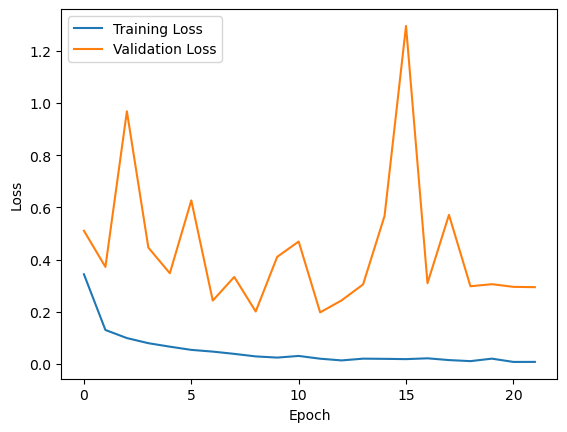

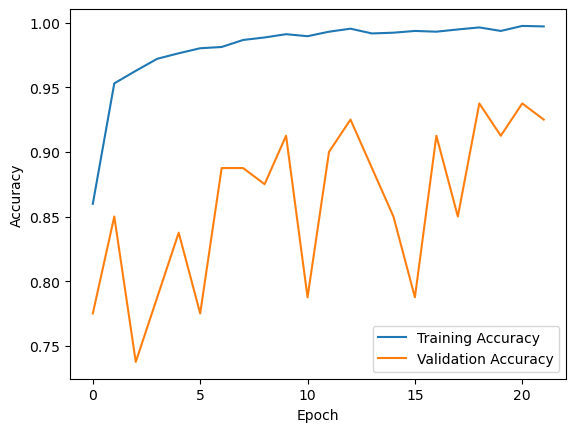

2023-07-26 16:46:01.250089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 8s 385ms/step - loss: 1.9472 - accuracy: 0.7340
Test Loss: 1.9472198486328125
Test Accuracy: 0.7339743375778198


2023-07-26 16:46:10.207645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 8s 380ms/step
              precision    recall  f1-score   support

           0       0.99      0.29      0.45       234
           1       0.70      1.00      0.82       390

    accuracy                           0.73       624
   macro avg       0.84      0.65      0.64       624
weighted avg       0.81      0.73      0.69       624

Overall recall 0.7339743589743589


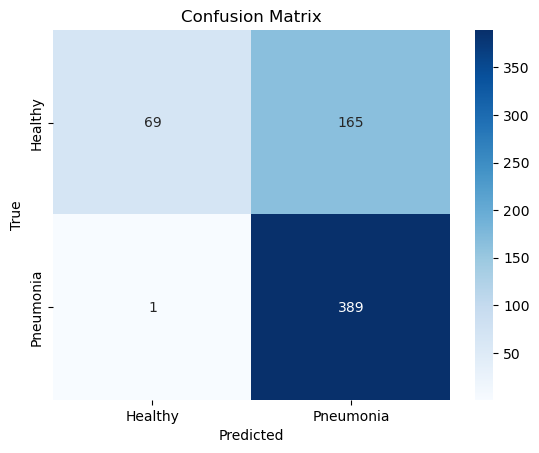

2023-07-26 16:46:19.317419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 8s 372ms/step


2023-07-26 16:46:27.801408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3/3 [==============================] - 1s 256ms/step


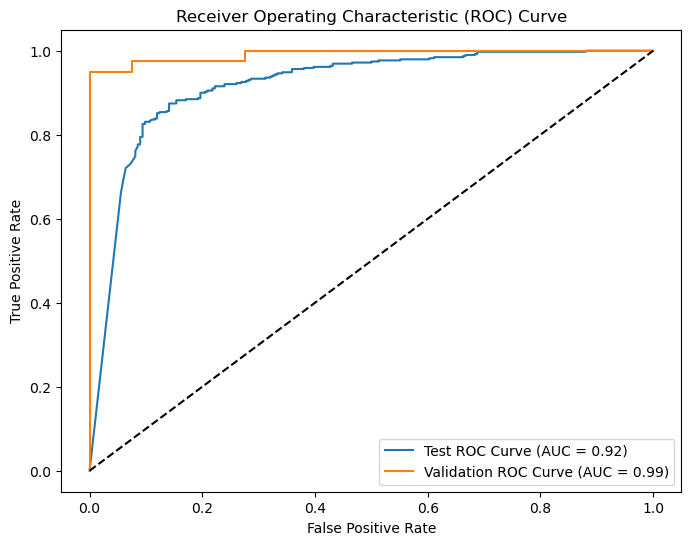

In [15]:
evaluation(CNN_model_2, CNN_history)


#### Model Evaluation

I used the test dataset to evaluate the performance of the model on previously unseen data. The model achieved an accuracy of 73.40% on the test set, which was 6 percentage points lower than the baseline model. The test loss increased as well from 0.95 on the baseline model to 1.95. 

The confusion matrix provided valuable insights into the model's performance by revealing the following:

True Positive (TP): The model correctly identified 389 Pneumonia cases as positive instances.
True Negative (TN): The model correctly identified 69 Normal cases as negative instances.
False Positive (FP): The model misclassified 165 Normal cases as Pneumonia, leading to false positives.
False Negative (FN): The model missed one Pneumonia case, resulting in one false negative.

The recall for Pneumonia cases in the test set was 1.00, indicating the model's strong ability to correctly identify positive cases. However, the recall for Normal cases was only 0.29 (lower than model 1), suggesting a lower sensitivity in correctly recognizing Normal cases. The overall recall for the model was 73.4 which was a few percentage points lower than the overall recall of model 1.

Furthermore, the ROC AUC score for the test set was 0.92 which is just slightly lower than the baseline model's at 0.91.

The model demonstrated promising results, particularly in accurately identifying Pneumonia cases. However, similar to the baseline model, it also exhibited limitations in correctly classifying Normal cases. It's likely that the model overfitted to the training data. 


In [16]:
# Save Model 
CNN_model_2.save('CNN_model_2.h5')

### Model 3

Things to add to the second model to try and increase performance and decrease overfitting:
1. Batch normalization after each convolutional layers to reduce overfitting and improve generalizaton. 
2. More dense layers with dropout to increase complexity while adding regularization. 


In [17]:
CNN_model_3 = Sequential(name='CNN_model_3')

# 1st Conv2D layer
CNN_model_3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
CNN_model_3.add(BatchNormalization())
CNN_model_3.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Conv2D layer
CNN_model_3.add(Conv2D(64, (3, 3), activation='relu'))
CNN_model_3.add(BatchNormalization())
CNN_model_3.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Conv2D layer
CNN_model_3.add(Conv2D(128, (3, 3), activation='relu'))
CNN_model_3.add(BatchNormalization())
CNN_model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer
CNN_model_3.add(Flatten())

# Dense layers
CNN_model_3.add(Dense(256, activation='relu'))
CNN_model_3.add(Dropout(0.5))
CNN_model_3.add(Dense(128, activation='relu'))
CNN_model_3.add(Dropout(0.5))
CNN_model_3.add(Dense(64, activation='relu'))
CNN_model_3.add(Dropout(0.5))

# Output layer
CNN_model_3.add(Dense(1, activation='sigmoid'))


In [18]:
# Run CNN model 3
CNN_history = run_model(CNN_model_3)


Epoch 1/100


2023-07-26 16:46:30.013715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


161/161 [==============================] - ETA: 0s - loss: 3.9155 - accuracy: 0.7787

2023-07-26 16:50:49.251993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


161/161 [==============================] - 261s 2s/step - loss: 3.9155 - accuracy: 0.7787 - val_loss: 38.4762 - val_accuracy: 0.5000
Epoch 2/100
161/161 [==============================] - 270s 2s/step - loss: 0.5879 - accuracy: 0.8133 - val_loss: 26.6683 - val_accuracy: 0.5000
Epoch 3/100
161/161 [==============================] - 260s 2s/step - loss: 0.3943 - accuracy: 0.8342 - val_loss: 14.3041 - val_accuracy: 0.5000
Epoch 4/100
161/161 [==============================] - 259s 2s/step - loss: 0.3526 - accuracy: 0.8090 - val_loss: 21.3231 - val_accuracy: 0.5375
Epoch 5/100
161/161 [==============================] - 261s 2s/step - loss: 0.3855 - accuracy: 0.8469 - val_loss: 15.4389 - val_accuracy: 0.5250
Epoch 6/100
161/161 [==============================] - 258s 2s/step - loss: 0.3032 - accuracy: 0.8686 - val_loss: 0.3464 - val_accuracy: 0.8875
Epoch 7/100
161/161 [==============================] - 258s 2s/step - loss: 0.2478 - accuracy: 0.8925 - val_loss: 2.9575 - val_accuracy: 0.7250

Model: "CNN_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     256       
 hNormalization)                                                 
                                                       

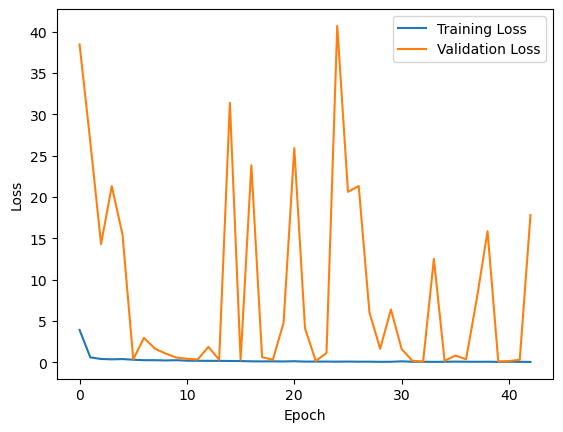

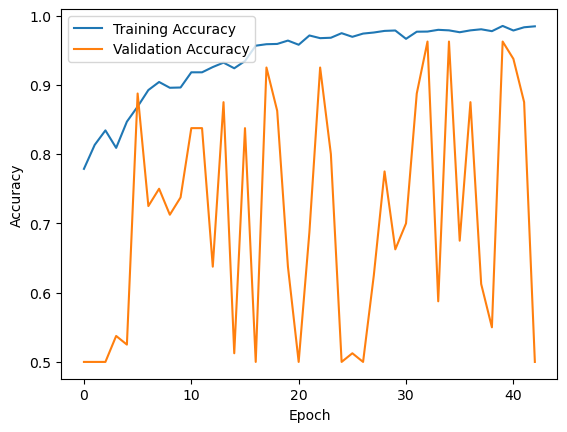

2023-07-26 20:24:20.864869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 10s 469ms/step - loss: 1.3544 - accuracy: 0.8173
Test Loss: 1.354378342628479
Test Accuracy: 0.817307710647583


2023-07-26 20:24:31.538858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 10s 459ms/step
              precision    recall  f1-score   support

           0       0.96      0.53      0.69       234
           1       0.78      0.99      0.87       390

    accuracy                           0.82       624
   macro avg       0.87      0.76      0.78       624
weighted avg       0.85      0.82      0.80       624

Overall recall 0.8173076923076923


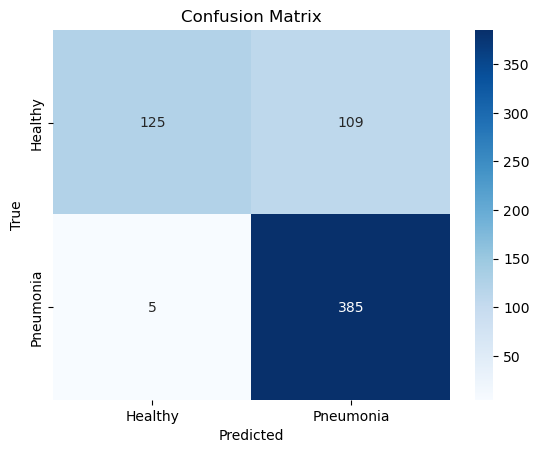

2023-07-26 20:24:42.289687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 10s 465ms/step


2023-07-26 20:24:52.652343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3/3 [==============================] - 2s 353ms/step


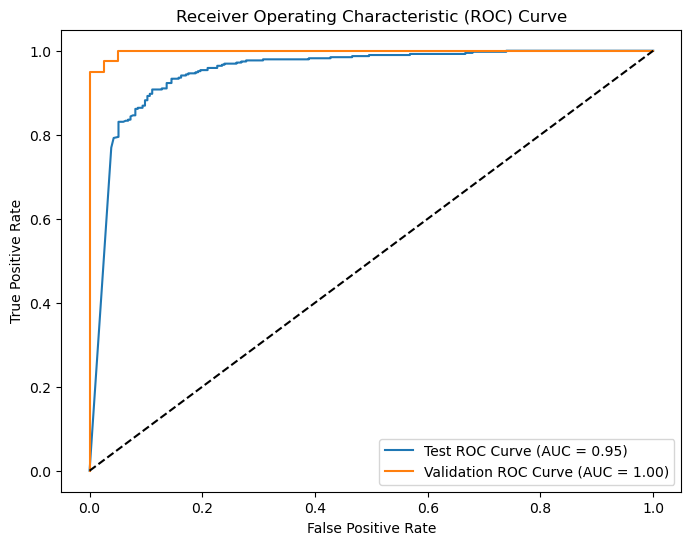

In [19]:
evaluation(CNN_model_3, CNN_history)

#### Model Evaluation
Using the test dataset, model 3 achieved an accuracy of 81.73%, indicating its overall correctness in predicting both classes. This was an improvement from both previous models. The loss was 1.35 which was higher than the baseline but lower than the second model. 

The confusion matrix for model 3 provided the following insights into its performance:

True Positive (TP): The model correctly identified 385 Pneumonia cases as positive instances.
True Negative (TN): The model correctly identified 125 Normal cases as negative instances.
False Positive (FP): The model misclassified 109 Normal cases as Pneumonia, leading to false positives.
False Negative (FN): The model missed five Pneumonia cases, resulting in false negatives.

The recall for Pneumonia cases in the test set was 0.99, indicating a strong ability to correctly identify positive cases. However, the recall for Normal cases was 0.53, suggesting there is still room for improvement in correctly recognizing Normal cases, though it is much improved over the last two models. The overall recall for the model was 0.82 which is the highest yet.

Furthermore, the area under the ROC AUC score for the test set was 0.95. This is promising as it is the highest ROC AUC score of the three models. 

In [20]:
CNN_model_3.save('CNN_model_3.h5')

## Transfer Learning using Xception
***

### MODEL 4

In my 4th model, I am trying a new approach to enhance the accuracy of Pneumonia detection. Instead of building a CNN from scratch, I will leverage the base layers of a pretrained model called Xception. By doing so, I can take advantage of Xception's well-learned feature extraction capabilities, which may lead to more accurate results.

The Xception model has been trained on a large dataset and has learned to detect a wide range of features from images. I will use these pretrained layers as the foundation and then add dense layers on top for classification. This transfer learning technique allows me to leverage the knowledge captured by Xception in differentiating between features in images, which could greatly benefit our Pneumonia detection task.

With the addition of dense layers, Model 4 will perform high-level reasoning and classification, refining the extracted features from Xception to make more accurate predictions. This approach has the potential to yield better generalization and robustness.

By combining the power of pretrained Xception layers with custom dense layers, I aim to achieve a more accurate and reliable model for Pneumonia detection. This new method of modeling could lead to improved results, and I am excited to evaluate the model on the test set to see its performance in comparison to the previous models. 

In [21]:
# Initialize Base 
xception_base = Xception(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3))

# Define Model Architecture with xception base and model 3's dense layers
CNN_model_4 = Sequential(name='CNN_model_4')

# Xception base layers
CNN_model_4.add(xception_base)

# Flatten layer
CNN_model_4.add(layers.Flatten())

# Dense layers
CNN_model_4.add(Dense(256, activation='relu'))
CNN_model_4.add(Dropout(0.5))
CNN_model_4.add(Dense(128, activation='relu'))
CNN_model_4.add(Dropout(0.5))
CNN_model_4.add(Dense(64, activation='relu'))
CNN_model_4.add(Dropout(0.5))

# Output layer
CNN_model_4.add(Dense(1, activation='sigmoid'))

# Make the Xception base untrainable so as to utilize its previous training
xception_base.trainable = False

# Double check what layers are trainable
for layer in CNN_model_4.layers:
    print(layer.name, layer.trainable)
    
# Check how many trainable weights are in the model 
print(len(CNN_model_4.trainable_weights))


xception False
flatten_3 True
dense_8 True
dropout_4 True
dense_9 True
dropout_5 True
dense_10 True
dropout_6 True
dense_11 True
8


In [22]:
# run combined model
CNN_history = run_model(CNN_model_4)

Epoch 1/100


2023-07-26 20:24:56.767194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


161/161 [==============================] - ETA: 0s - loss: 2.2795 - accuracy: 0.8187

2023-07-26 20:29:56.339804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


161/161 [==============================] - 305s 2s/step - loss: 2.2795 - accuracy: 0.8187 - val_loss: 0.7250 - val_accuracy: 0.8125
Epoch 2/100
161/161 [==============================] - 302s 2s/step - loss: 0.2915 - accuracy: 0.8764 - val_loss: 0.5524 - val_accuracy: 0.8500
Epoch 3/100
161/161 [==============================] - 304s 2s/step - loss: 0.2544 - accuracy: 0.8944 - val_loss: 1.0630 - val_accuracy: 0.8125
Epoch 4/100
161/161 [==============================] - 304s 2s/step - loss: 0.2634 - accuracy: 0.8859 - val_loss: 1.1408 - val_accuracy: 0.7750
Epoch 5/100
161/161 [==============================] - 305s 2s/step - loss: 0.2405 - accuracy: 0.9064 - val_loss: 0.7772 - val_accuracy: 0.8000
Epoch 6/100
161/161 [==============================] - 2181s 14s/step - loss: 0.2149 - accuracy: 0.9094 - val_loss: 0.5484 - val_accuracy: 0.8500
Epoch 7/100
161/161 [==============================] - 783s 5s/step - loss: 0.2271 - accuracy: 0.9028 - val_loss: 0.5957 - val_accuracy: 0.8000
Ep

Model: "CNN_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_8 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                

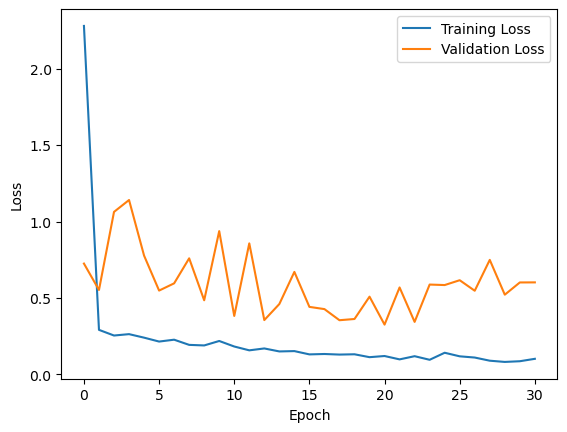

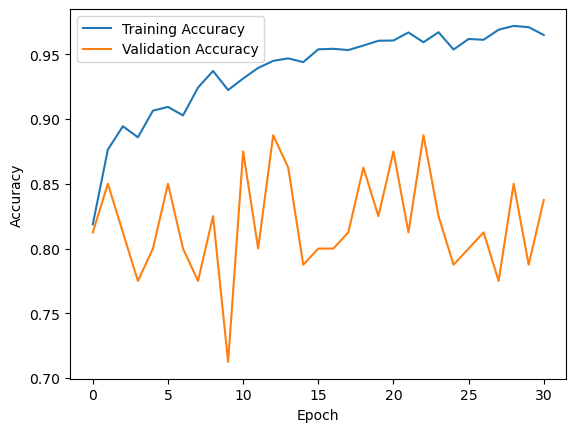

2023-07-27 12:53:27.449217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 35s 2s/step - loss: 0.6056 - accuracy: 0.8205
Test Loss: 0.6055959463119507
Test Accuracy: 0.8205128312110901


2023-07-27 12:54:03.557117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 34s 2s/step
              precision    recall  f1-score   support

           0       0.96      0.55      0.70       234
           1       0.78      0.98      0.87       390

    accuracy                           0.82       624
   macro avg       0.87      0.77      0.78       624
weighted avg       0.85      0.82      0.81       624

Overall recall 0.8205128205128205


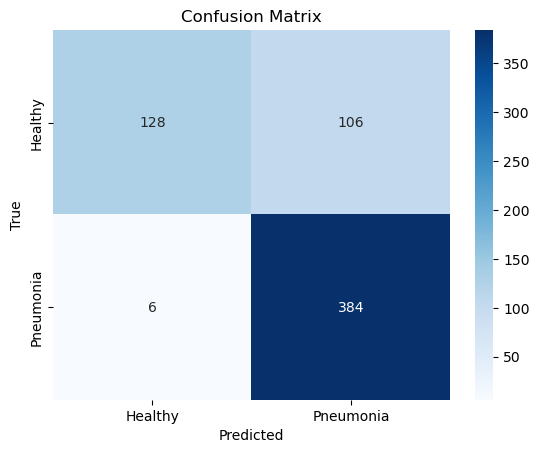

2023-07-27 12:54:38.159247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 36s 2s/step


2023-07-27 12:55:14.463540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3/3 [==============================] - 5s 1s/step


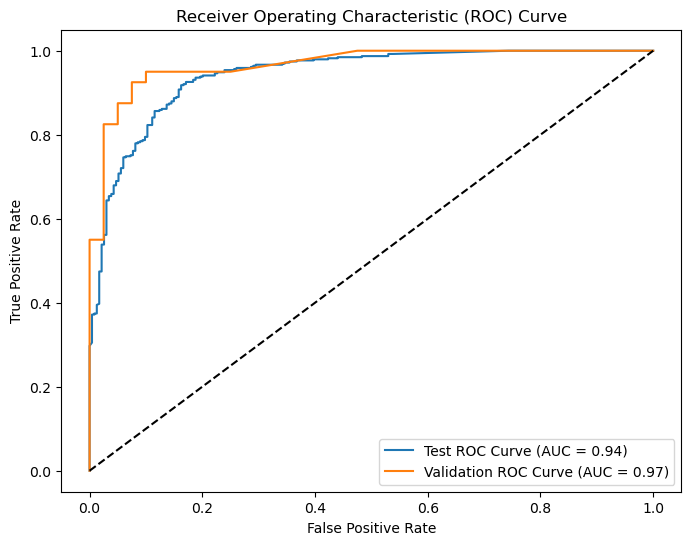

In [26]:
evaluation(CNN_model_4, CNN_history)

#### Model Evaluation:

Model 4 employs transfer learning with the Xception model's base layers followed by additional custom dense layers for Pneumonia detection. This approach aims to leverage the knowledge learned by Xception from a vast dataset and refine it with the added dense layers for improved accuracy.

Upon evaluating the model on the test set, Model 4 achieved an accuracy of 82.05%, indicating its overall correctness in predicting both classes, similar to the performance of Model 3, but with a lower loss of 0.6. 

The confusion matrix for model 4 provided the following insights into its performance:

True Positive (TP): The model correctly identified 384 Pneumonia cases as positive instances.
True Negative (TN): The model correctly identified 128 Normal cases as negative instances.
False Positive (FP): The model misclassified 106 Normal cases as Pneumonia, leading to false positives.
False Negative (FN): The model missed six Pneumonia cases, resulting in false negatives.


Analyzing the precision and recall, the model demonstrates good performance for Pneumonia cases with precision of 0.78 and recall of 0.98. However, as observed in Model 3, its performance for Normal cases remains lower, with a recall of 0.55. This suggests that, like the other models, Model 4 is very effective in correctly identifying Pneumonia cases but may benefit from further improvement in recognizing Normal cases. And the overall recall, which considers the model's performance across both classes, is 0.8205, which remains similiar to Model 3.

Furthermore, the ROC AUC score for the test set is 0.94, indicating that Model 4 demonstrates strong discriminatory power in distinguishing between Pneumonia and Normal cases. This score is consistent with Model 3, suggesting that the transfer learning approach has not negatively impacted the model's ability to differentiate between the two classes.

Overall, the transfer learning from Xception shows little improvement in correctly classifying Normal cases, but continues to demonstrate excellent recall with Pneumonia cases. 

In [23]:
CNN_model_4.save('CNN_model_4.h5')

### MODEL 5

In [27]:
# Define model architecture
CNN_model_5 = Sequential(name='CNN_model_5')

# Xception base layers
CNN_model_5.add(xception_base)

# Flatten layer
CNN_model_5.add(layers.Flatten())

# Dense layers
CNN_model_5.add(Dense(256, activation='relu'))
CNN_model_5.add(Dropout(0.5))
CNN_model_5.add(Dense(128, activation='relu'))
CNN_model_5.add(Dropout(0.5))
CNN_model_5.add(Dense(64, activation='relu'))
CNN_model_5.add(Dropout(0.5))

# Output layer
CNN_model_5.add(Dense(1, activation='sigmoid'))


xception_base.trainable = False

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# Compile the model
CNN_model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
history = CNN_model_5.fit(train_data, epochs=100, validation_data=val_data, callbacks=[early_stopping])
   
#Evaluate the model
test_loss, test_accuracy = CNN_model_5.evaluate(test_data, steps=len(test_data))
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Epoch 1/100


2023-07-27 12:55:45.830393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


161/161 [==============================] - ETA: 0s - loss: 1.8619 - accuracy: 0.8049

2023-07-27 13:00:50.986817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


161/161 [==============================] - 310s 2s/step - loss: 1.8619 - accuracy: 0.8049 - val_loss: 0.4716 - val_accuracy: 0.8375
Epoch 2/100
161/161 [==============================] - 305s 2s/step - loss: 0.2944 - accuracy: 0.8853 - val_loss: 0.6886 - val_accuracy: 0.8250
Epoch 3/100
161/161 [==============================] - 305s 2s/step - loss: 0.2777 - accuracy: 0.8839 - val_loss: 1.2410 - val_accuracy: 0.7500
Epoch 4/100
161/161 [==============================] - 307s 2s/step - loss: 0.2686 - accuracy: 0.9022 - val_loss: 0.4238 - val_accuracy: 0.8875
Epoch 5/100
161/161 [==============================] - 306s 2s/step - loss: 0.2565 - accuracy: 0.8952 - val_loss: 0.5999 - val_accuracy: 0.8000
Epoch 6/100
161/161 [==============================] - 306s 2s/step - loss: 0.2166 - accuracy: 0.9163 - val_loss: 0.6710 - val_accuracy: 0.8125
Epoch 7/100
161/161 [==============================] - 306s 2s/step - loss: 0.2022 - accuracy: 0.9342 - val_loss: 0.5713 - val_accuracy: 0.8500
Epoc

2023-07-27 16:54:35.381477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 33s 2s/step - loss: 0.6882 - accuracy: 0.8413
Test Loss: 0.688163697719574
Test Accuracy: 0.8413461446762085


Model: "CNN_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_12 (Dense)            (None, 256)               25690368  
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 64)                

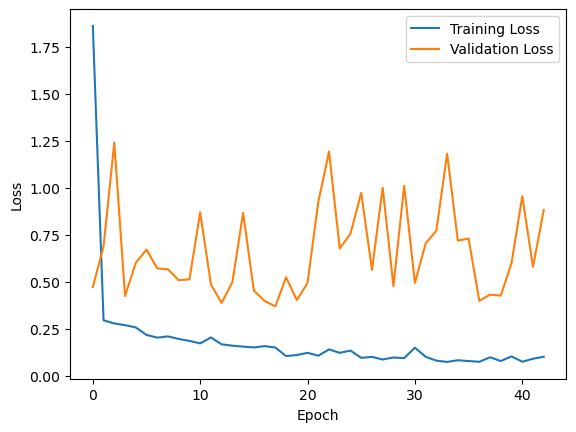

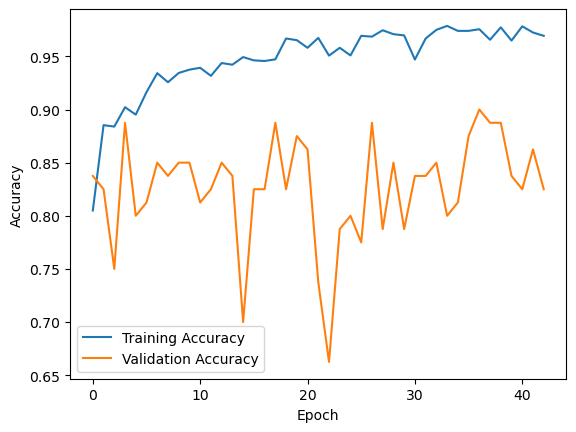

2023-07-27 16:55:09.486005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 32s 2s/step - loss: 0.6882 - accuracy: 0.8413
Test Loss: 0.688163697719574
Test Accuracy: 0.8413461446762085


2023-07-27 16:55:42.678385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 33s 2s/step
              precision    recall  f1-score   support

           0       0.95      0.61      0.74       234
           1       0.81      0.98      0.89       390

    accuracy                           0.84       624
   macro avg       0.88      0.79      0.81       624
weighted avg       0.86      0.84      0.83       624

Overall recall 0.8413461538461539


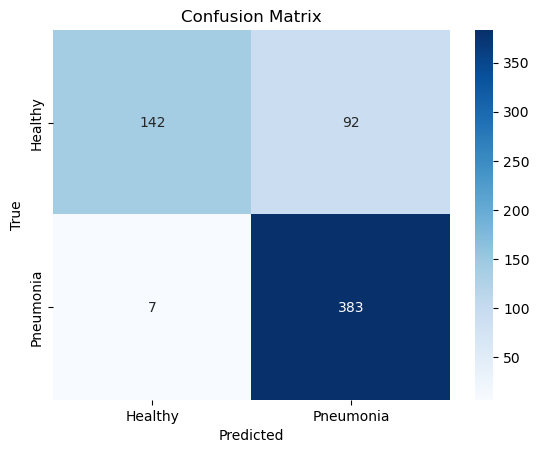

2023-07-27 16:56:16.635789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 32s 2s/step


2023-07-27 16:56:49.429024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3/3 [==============================] - 5s 1s/step


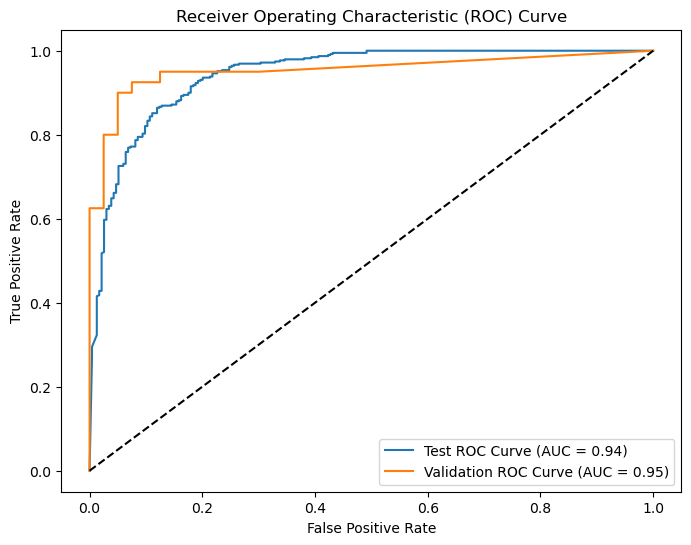

In [28]:
evaluation(CNN_model_5, history)

#### Model Evaluation:
The final model, was built upon transfer learning with the Xception model's base layers, followed by custom dense layers for Pneumonia detection. The patience level was raised from 10 to 25 with the hope that the model would have more time to converge. 

When evaluating Model 5 on the test set, it achieved an accuracy of 84.13% which is the highest accuracy of any of the models as well as a loss value of 0.69 which is similiar to model 4. The final model did run for more epochs than model 4, and the higher accuracy suggests that the higher patience level improved the model's performance.

The confusion matrix for model 5 provided the following insights into its performance:

True Positive (TP): The model correctly identified 383 Pneumonia cases as positive instances.
True Negative (TN): The model correctly identified 142 Normal cases as negative instances.
False Positive (FP): The model misclassified 92 Normal cases as Pneumonia, leading to false positives.
False Negative (FN): The model missed seven Pneumonia cases, resulting in false negatives.


Analyzing the recall, the model still demonstrates excellence in correctly identifying Pneumonia cases with a recall of 0.98. Moreover, it shows better performance for Normal cases with a recall of 0.61 compared to previous models. The overall recall went up to 0.84. 


Furthermore, the ROC AUC score for the test set is 0.94. This high ROC AUC score, while similiar to all the other models', confirms the model's ability to effectively differentiate between the two classes and is an essential metric for evaluating the final model's performance.

In conclusion, the final model with transfer learning from Xception shows significant improvement from the baseline model, accurately detecting both Pneumonia and Normal cases. The model's robustness is reflected in its high accuracy and good recall for both classes. These results are promising and showcase the potential of deep learning models in contributing to the advancement of medical image analysis for Pneumonia detection.

In [29]:
CNN_model_5.save('CNN_model_5.h5')

In [30]:
CNN_model_5 = load_model('CNN_model_5.h5')

## Results and Conclusions

#### Results:
In this project, I applied Convolutional Neural Networks (CNNs) and transfer learning techniques to develop and evaluate several models for the task of Pneumonia detection from X-ray images. Five different models were implemented and compared, each with varying architectures and hyperparameters.

Model Performance Summary:
1. Model 1 achieved an accuracy of 79.33% on the test set, with an overall recall of 0.7933. It showed promising results in identifying Pneumonia cases accurately but had room for improvement in recognizing Normal cases.

2. Model 2 demonstrated an accuracy of 73.00% on the test set, with an overall recall of 0.73. This model showed lower accuracy and overall recall than the baseline while maintaining a high recall for Pneumonia cases. 

3. Model 3, demonstrated an accuracy of 82.00% on the test set, with an overall recall of 0.8205. This model showcased improved performance in correctly identifying Normal cases while maintaining a high recall for Pneumonia cases.

4. Model 4, was based on Xception's base layers and fine tuned on Dense layers. Besides demonstrating a significantly lower loss score on the test set, it attained similiar results to Model 3 with an accuracy of 82.05% on the test set, with an overall recall of 0.82.

5. Model 5, the final model, also based on Xception's base layers, was trained with a higher patience level than the other models allowing for a longer convergence time during training. It achieved an accuracy of 84.13% on the test set, with an overall recall of 0.84. It yielded the best results overall and a significant improvement from the baseline model. 

#### Conclusions:
* The transfer learning with Xception's base layers and a longer patience level significantly enhanced the performance of Pneumonia detection from X-ray images. The final model demonstrated superior accuracy and recall compared to the baseline model. The use of pre-trained model enabled the final model to leverage rich learned features from large-scale datasets, leading to improved generalization and robustness.

* The experimentation with hyperparameters, such as patience level and dropout rates, provided valuable insights into model training and convergence. Adjusting these parameters allowed me to fine-tune the models, leading to more optimal performance.

* The final AI-powered pneumonia detection model represents a significant step forward in assisting radiologists with accurate and efficient interpretation of chest X-rays. 

* The developed model's success in detecting pneumonia showcases its potential to empower healthcare professionals with advanced AI-driven solutions.

* There are limitations to be addressed to further optimize the model's performance. The class imbalance between Normal and Pneumonia cases remains a challenge, and future work should focus on methods such as weighted regularization and data augmentation to alleviate this issue. 

* Additionally, further regularization techniques can be explored to prevent overfitting and enhance the model's generalization on diverse datasets. 